# Walking

In [1]:
import sys
sys.path.append("../../../")

import torch as th

from mowl.datasets.ppi_yeast import PPIYeastSlimDataset

from mowl.embeddings.graph_based.dl2vec.model import DL2Vec
from gensim.models import Word2Vec
import pickle as pkl
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mowl.graph.factory import parser_factory
from mowl.graph.edge import Edge


import gensim
import logging
import time

logging.basicConfig(set_level = logging.INFO)


## Projecting the ontology
First we need to get a graph from an ontology. The following function will do it:

In [2]:
def getOntProjection():
    logging.info("Creating dataset...")
    start = time.time()
    dataset = PPIYeastSlimDataset()
    end = time.time()
    logging.info("Dataset created in %f seconds", end-start)

    logging.info("Projecting graph...")
    start = time.time()
    parser = parser_factory(
        "dl2vec", # taxonomy, taxonomy_rels, owl2vec_star
        dataset.ontology, 
        bidirectional_taxonomy=True)

    edges = parser.parse()
    end = time.time()
    logging.info("Graph projected in %f seconds", end - start)
    entities, _ = Edge.getEntitiesAndRelations(edges)
    return edges, entities

## Learning embeddings with Word2Vec

Once the walks are generated, we will use them to learn embeddings using the Word2Vec model:

In [3]:
def learnEmbeddingsWithWord2Vec(corpus_path, entities):
    logging.info("Learning embeddings..")
    start = time.time()

    sentences = gensim.models.word2vec.LineSentence(corpus_path)

    model = gensim.models.Word2Vec(
        sentences, 
        sg=1, 
        min_count=1, 
        vector_size=100, 
        window = 10, 
        epochs = 10, 
        workers = 16)
    end = time.time()
    logging.info("Embeddings learned in %f seconds", end - start)
    
    vectors = model.wv

    embeddings = {}
    for node in entities:
        if node.startswith("4932"):
            embeddings[node] = vectors[node]
        
    return embeddings, model.vector_size

## Plotting TSNE representations
Once the embeddings are ready, we can use them for different tasks. Here we use the TSNE method to have a visual representation of them:

In [4]:
def plotTSNE(embeddings, size):
    
    ec_numbers = {}
    with open('data/yeast_ec.tab') as f:
        next(f)
        for line in f:
            it = line.strip().split('\t', -1)
            if len(it) < 5:
                continue
            if it[3]:
                prot_id = it[3].split(';')[0]
                prot_id = '{0}'.format(prot_id)    
                ec_numbers[prot_id] = it[4]
                
    ec_dict = {}
    for prot in ec_numbers:
        if prot in embeddings:
            ec_dict[prot] = embeddings[prot]

    embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

    for i, emb in enumerate(ec_dict.values()):
        embeds[i, :] = emb
    nodemap = {}
    for i, m in enumerate(ec_dict.keys()):
        nodemap[i] = m


    X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

    
    classes = {'0': [[], []]}
    for item in nodemap.items():
        k, v = item
        if v in ec_numbers:
            ec = ec_numbers[v].split('.')[0]
            if ec not in classes:
                classes[ec] = [[], []]
            classes[ec][0].append(X[k, 0])
            classes[ec][1].append(X[k, 1])

    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
    fig, ax = plt.subplots(figsize=(20, 20))

    for ec, items in classes.items():
        if ec == '0':
            continue
        color = next(colors)
        ax.scatter(items[0], items[1], color=color, label=ec)

    ax.legend()
    ax.grid(True)
    plt.show()

## Putting all together and trying different walking methods
Now, we can use the functions defined above and test them with the walking methods existing in mOWL

In [5]:
from mowl.walking.node2vec.model import Node2Vec as N2V
from mowl.walking.deepwalk.model import DeepWalk as DW
from mowl.walking.walkRdfAndOwl.model import WalkRDFAndOWL as WRO

In [6]:
edges, entities = getOntProjection() 

INFO:root:Creating dataset...
INFO:root:Dataset created in 0.435111 seconds
INFO:root:Projecting graph...


INFO: Number of ontology classes: 11020


INFO:root:Graph projected in 14.389790 seconds


### DeepWalk

INFO:root:Walking..


Starting pool...+ started processing 0
+ started processing 1
+ started processing 4
+ started processing 5
+ started processing 3
+ started processing 2
+ started processing 6
+ started processing 7
+ started processing 8
+ started processing 10
+ started processing 11
+ started processing 9
+ started processing 13
+ started processing 14
+ started processing 12
+ started processing 15


INFO:root:Walks generated in 2.290906 seconds
INFO:root:Learning embeddings..
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 69007 words, keeping 7249 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 139051 words, keeping 8605 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 214013 words, keeping 9400 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 281561 words, keeping 9815 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 351998 words, keeping 10121 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 422094 words, keeping 10358 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 493918 words, keeping 10534 word types
INFO:gensim.models

- finished processing 10 after 1427
- finished processing 8 after 1434
- finished processing 1 after 1448
- finished processing 6 after 1450
- finished processing 2 after 1456
- finished processing 3 after 1457
- finished processing 5 after 1457
- finished processing 0 after 1458
- finished processing 9 after 1453
- finished processing 4 after 1459
- finished processing 7 after 1460
- finished processing 11 after 1457
- finished processing 14 after 1507
- finished processing 15 after 1504
- finished processing 12 after 1511
- finished processing 13 after 1514
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #110000, processed 795286 words, keeping 10877 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #120000, processed 865746 words, keeping 10917 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #130000, processed 933023 words, keeping 10945 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #140000, processed 1003755 words, keeping 10967 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #150000, processed 1074447 words, keeping 10992 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #160000, processed 1150211 words, keeping 11009 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #170000, processed 1222996 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #180000, processed 1292606 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #190000, processed 1362342 words, keeping 11020 word types
INFO:gensim.models.wor

INFO:gensim.models.word2vec:PROGRESS: at sentence #870000, processed 6264374 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #880000, processed 6335534 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #890000, processed 6404222 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #900000, processed 6473000 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #910000, processed 6544672 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #920000, processed 6615088 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #930000, processed 6687165 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #940000, processed 6756558 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #950000, processed 6828902 words, keeping 11020 word types
INFO:gensim.models.

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 2 : training on 7935607 raw words (7628715 effective words) took 10.5s, 725137 effective words/s
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 9.07% examples, 687123 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 18.35% examples, 693544 words/s, in_qsize 14, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 27.20% examples, 688165 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 37.56% examples, 698041 words/s, in_qsize 12, out_qsize 3
IN

INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 7.40% examples, 551850 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 18.48% examples, 693900 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 27.84% examples, 700901 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 36.92% examples, 692356 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 47.19% examples, 696061 words/s, in_qsize 10, out_qsize 5
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 58.24% examples, 719558 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 67.60% examples, 714218 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 77.20% examples, 711511 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 7 - PROGRESS: at 88.31% examples, 725386 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.w

INFO:root:Embeddings learned in 108.050226 seconds
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1712 samples in 0.001s...
[t-SNE] Computed neighbors for 1712 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1712
[t-SNE] Computed conditional probabilities for sample 1712 / 1712
[t-SNE] Mean sigma: 1.243232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.299110
[t-SNE] KL divergence after 4900 iterations: 1.099331


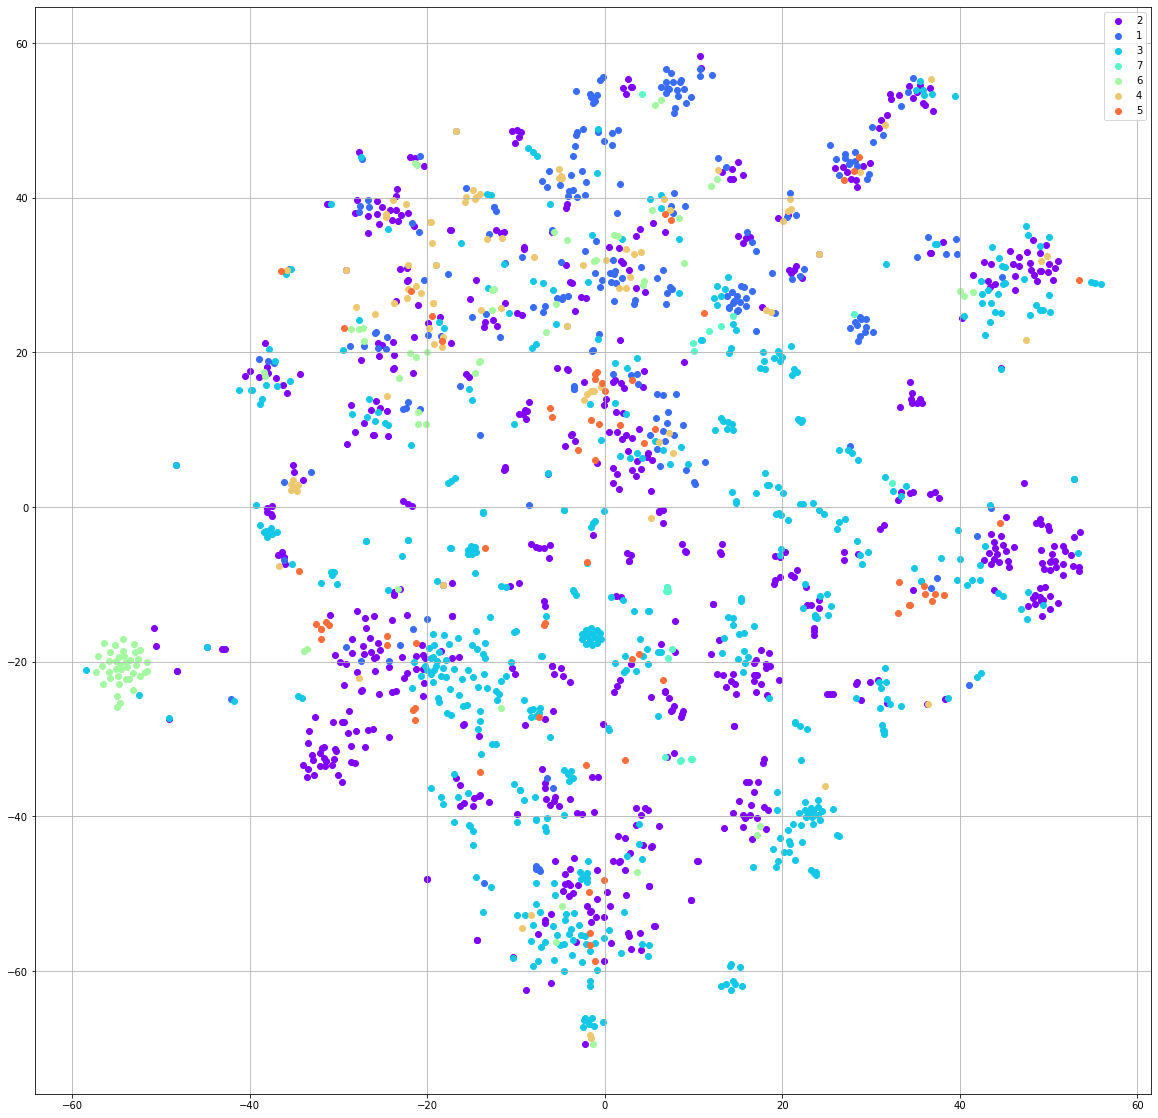

In [17]:
logging.info("Walking..")
start = time.time()
walksFile = "data/walksDeepwalk"
walker = DW(
        edges, 
        100, #num_walks 
        100, #walk_length 
        0.1, #alpha
        walksFile, #file to write the walks
        workers = 16, #num_workers,
    )

walker.walk()
end = time.time()
logging.info("Walks generated in %f seconds", end - start)

dwEmbeddings, size = learnEmbeddingsWithWord2Vec(walksFile, entities)


/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1712 samples in 0.001s...
[t-SNE] Computed neighbors for 1712 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1712
[t-SNE] Computed conditional probabilities for sample 1712 / 1712
[t-SNE] Mean sigma: 1.243232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.680542
[t-SNE] KL divergence after 5000 iterations: 1.093753


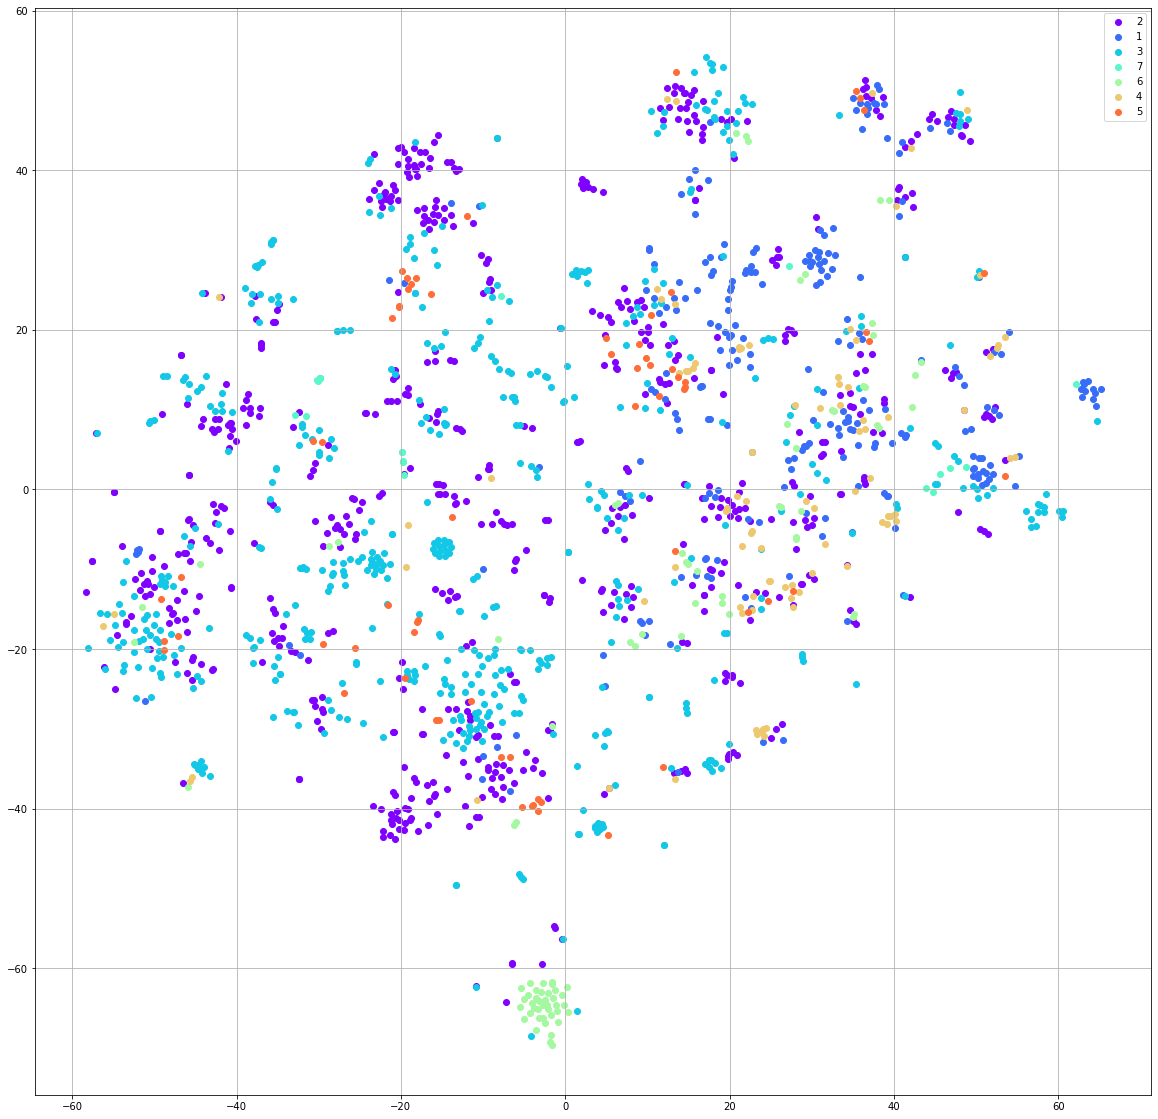

In [18]:
plotTSNE(dwEmbeddings, size)

## Node2Vec

In [20]:
logging.info("Walking..")
start = time.time()
walksFile = "data/walksNode2Vec"

walker = N2V(
        edges, 
        100, #num_walks 
        100, #walk_length 
        10, #p
        0.1, #q
        walksFile,
        workers = 16, #num_workers,
    )
    

walker.walk()
end = time.time()
logging.info("Walks generated in %f seconds", end - start)

n2vEmbeddings, size = learnEmbeddingsWithWord2Vec(walksFile, entities)


INFO:root:Walking..


Starting pool...+ started preprocessing probabilities...
Thread 0, nodes to process 368
Thread 1, nodes to process 379
Thread 3, nodes to process 387
Thread 4, nodes to process 375
Thread 10, nodes to process 362
Thread 2, nodes to process 393
Thread 9, nodes to process 390
Thread 11, nodes to process 402
Thread 14, nodes to process 386
Thread 8, nodes to process 400
Thread 7, nodes to process 390
Thread 5, nodes to process 382
Thread 6, nodes to process 391
Thread 13, nodes to process 393
Thread 12, nodes to process 411
Thread 15, nodes to process 389
* processing nodes is over
Thread 10, edges to process 15574
Thread 2, edges to process 15574
Thread 9, edges to process 15574
Thread 11, edges to process 15573
Thread 12, edges to process 15573
Thread 1, edges to process 15574
Thread 14, edges to process 15573
Thread 4, edges to process 15574
Thread 8, edges to process 15574
Thread 13, edges to process 15573
Thread 0, edges to process 15574
Thread 5, edges to process 15574
Thread 6, edg

INFO:root:Walks generated in 11.677869 seconds
INFO:root:Learning embeddings..
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 43610 words, keeping 6859 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 89229 words, keeping 8351 word types


- finished processing 13 after 5114
- finished processing 14 after 5129
- finished processing 12 after 5130
- finished processing 15 after 5253
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 134798 words, keeping 9132 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 179187 words, keeping 9618 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 226042 words, keeping 9983 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 273658 words, keeping 10209 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 320182 words, keeping 10398 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 367520 words, keeping 10548 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #90000, processed 417181 words, keeping 10636 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #100000, processed 468850 words, keeping 10737 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #110000, processed 517080 words, keeping 10805 word types
INFO:gensim.models.word2vec:PROGRESS: 

INFO:gensim.models.word2vec:PROGRESS: at sentence #790000, processed 3699216 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #800000, processed 3749289 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #810000, processed 3797679 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #820000, processed 3845344 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #830000, processed 3892563 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #840000, processed 3940125 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #850000, processed 3986146 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #860000, processed 4033513 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #870000, processed 4079917 words, keeping 11020 word types
INFO:gensim.models.

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 2 : training on 5167220 raw words (4683972 effective words) took 7.8s, 604192 effective words/s
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 10.60% examples, 498448 words/s, in_qsize 11, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 23.35% examples, 537839 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 3 - PROGRESS: at 35.71% examples, 550339 words/s, in_qsize 12, out_qsize 4
INFO:gensim.models.word2v

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 7 : training on 5167220 raw words (4684680 effective words) took 7.6s, 619110 effective words/s
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 10.98% examples, 514934 words/s, in_qsize 11, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 24.41% examples, 565331 words/s, in_qsize 16, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 37.48% examples, 579364 words/s, in_qsize 15, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 50.19% examples, 572419 words/s, in_qsize 15, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 63.37% examples, 572919 words/s, in_qsize 8, out_qsize 5
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 77.33% examples, 570184 words/s, in_qsize 16, out_qsize 5
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 92.42% examples, 579594 words/s, in_qsize 16, out_qsize 2
INFO:gensim.models.w

/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1712 samples in 0.000s...
[t-SNE] Computed neighbors for 1712 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1712
[t-SNE] Computed conditional probabilities for sample 1712 / 1712
[t-SNE] Mean sigma: 1.200023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.234833
[t-SNE] KL divergence after 5000 iterations: 1.170610


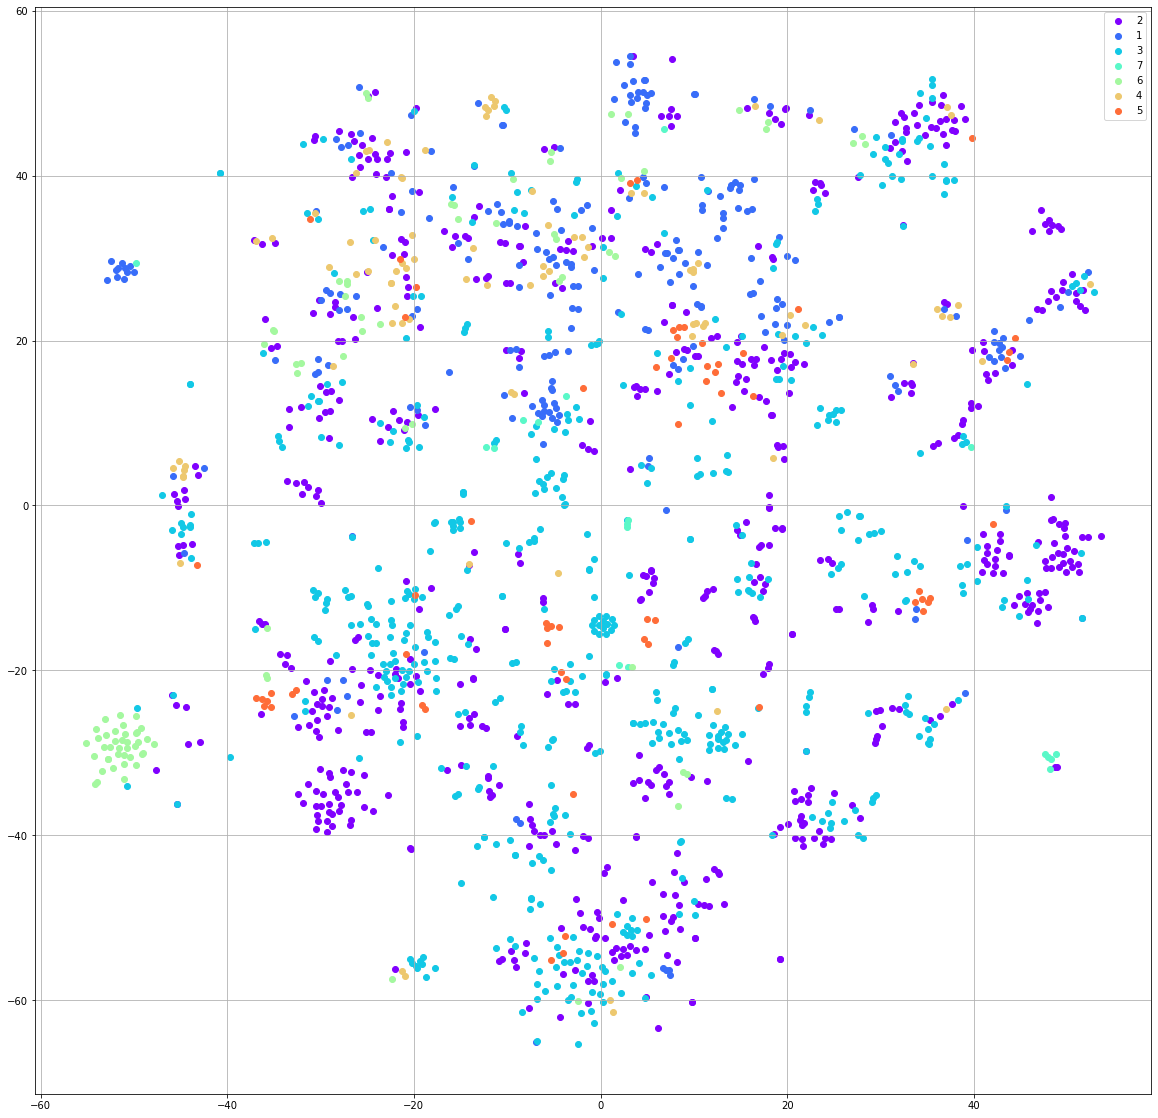

In [21]:
plotTSNE(n2vEmbeddings, size)

## Walking RDF and OWL

In [7]:
logging.info("Walking..")
start = time.time()
walksFile = "data/walksWalkRDFAndOWL"

walker = WRO(
        edges, 
        100, #num_walks 
        100, #walk_length 
        walksFile,
        workers = 16, #num_workers,
    )
    

walker.walk()
end = time.time()
logging.info("Walks generated in %f seconds", end - start)

wroEmbeddings, size = learnEmbeddingsWithWord2Vec(walksFile, entities)

INFO:root:Walking..


Starting pool...+ started processing 13
+ started processing 0
+ started processing 9
+ started processing 12
+ started processing 14
+ started processing 11
+ started processing 2
+ started processing 6
+ started processing 1
+ started processing 7
+ started processing 5
+ started processing 3
+ started processing 10
+ started processing 8
+ started processing 15
+ started processing 4


INFO:root:Walks generated in 3.322102 seconds
INFO:root:Learning embeddings..
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 128962 words, keeping 7252 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 255628 words, keeping 8574 word types


- finished processing 2 after 2025
- finished processing 0 after 2040
- finished processing 11 after 2043
- finished processing 7 after 2047
- finished processing 10 after 2046
- finished processing 6 after 2048
- finished processing 3 after 2047
- finished processing 8 after 2049
- finished processing 9 after 2051
- finished processing 4 after 2051
- finished processing 1 after 2052
- finished processing 5 after 2053
- finished processing 12 after 2132
- finished processing 15 after 2130
- finished processing 13 after 2135
- finished processing 14 after 2144
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 382370 words, keeping 9254 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 516786 words, keeping 9835 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 638924 words, keeping 10149 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 756132 words, keeping 10345 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 881820 words, keeping 10473 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 1002874 words, keeping 10591 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #90000, processed 1130084 words, keeping 10688 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #100000, processed 1253428 words, keeping 10761 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #110000, processed 1376458 words, keeping 10849 word types
INFO:gensim.models.word2vec:PROGR

INFO:gensim.models.word2vec:PROGRESS: at sentence #790000, processed 9792132 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #800000, processed 9917116 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #810000, processed 10037150 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #820000, processed 10157458 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #830000, processed 10277196 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #840000, processed 10406114 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #850000, processed 10527128 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #860000, processed 10647164 words, keeping 11029 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #870000, processed 10771544 words, keeping 11029 word types
INFO:gensim.

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 13614080 raw words (7618216 effective words) took 10.6s, 721874 effective words/s
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 6.24% examples, 485257 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 14.59% examples, 555286 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 23.32% examples, 593815 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 32.12% examples, 608905 words/s, in_qsize 30, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 40.28% examples, 608583 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 49.92% examples, 628785 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 57.45% examples, 620864 words/s, in_qsize 30, out_qsize 0
INFO:gensim.models

INFO:gensim.models.word2vec:EPOCH - 4 : training on 13614080 raw words (7619287 effective words) took 12.1s, 630234 effective words/s
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 6.33% examples, 488673 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 14.58% examples, 545431 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 24.06% examples, 603035 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 32.40% examples, 609453 words/s, in_qsize 28, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 39.99% examples, 602856 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 49.71% examples, 624676 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 57.30% examples, 618155 words/s, in_qsize 31, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 66.06% examples, 621282 words/s, in_qsize 30, out_qsi

INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 6.63% examples, 507889 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 16.66% examples, 633682 words/s, in_qsize 28, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 24.42% examples, 620766 words/s, in_qsize 25, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 32.83% examples, 623485 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 42.04% examples, 638288 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 50.33% examples, 637734 words/s, in_qsize 26, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 58.28% examples, 632189 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 67.41% examples, 640453 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 8 - PROGRESS: at 76.29% examples, 641830 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.w

INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=11029, vector_size=100, alpha=0.025)', 'datetime': '2022-01-30T14:10:34.120752', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-96-generic-x86_64-with-glibc2.27', 'event': 'created'}
INFO:root:Embeddings learned in 121.201347 seconds


/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1712 samples in 0.001s...
[t-SNE] Computed neighbors for 1712 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1712
[t-SNE] Computed conditional probabilities for sample 1712 / 1712
[t-SNE] Mean sigma: 1.258003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.512955
[t-SNE] KL divergence after 5000 iterations: 1.059402


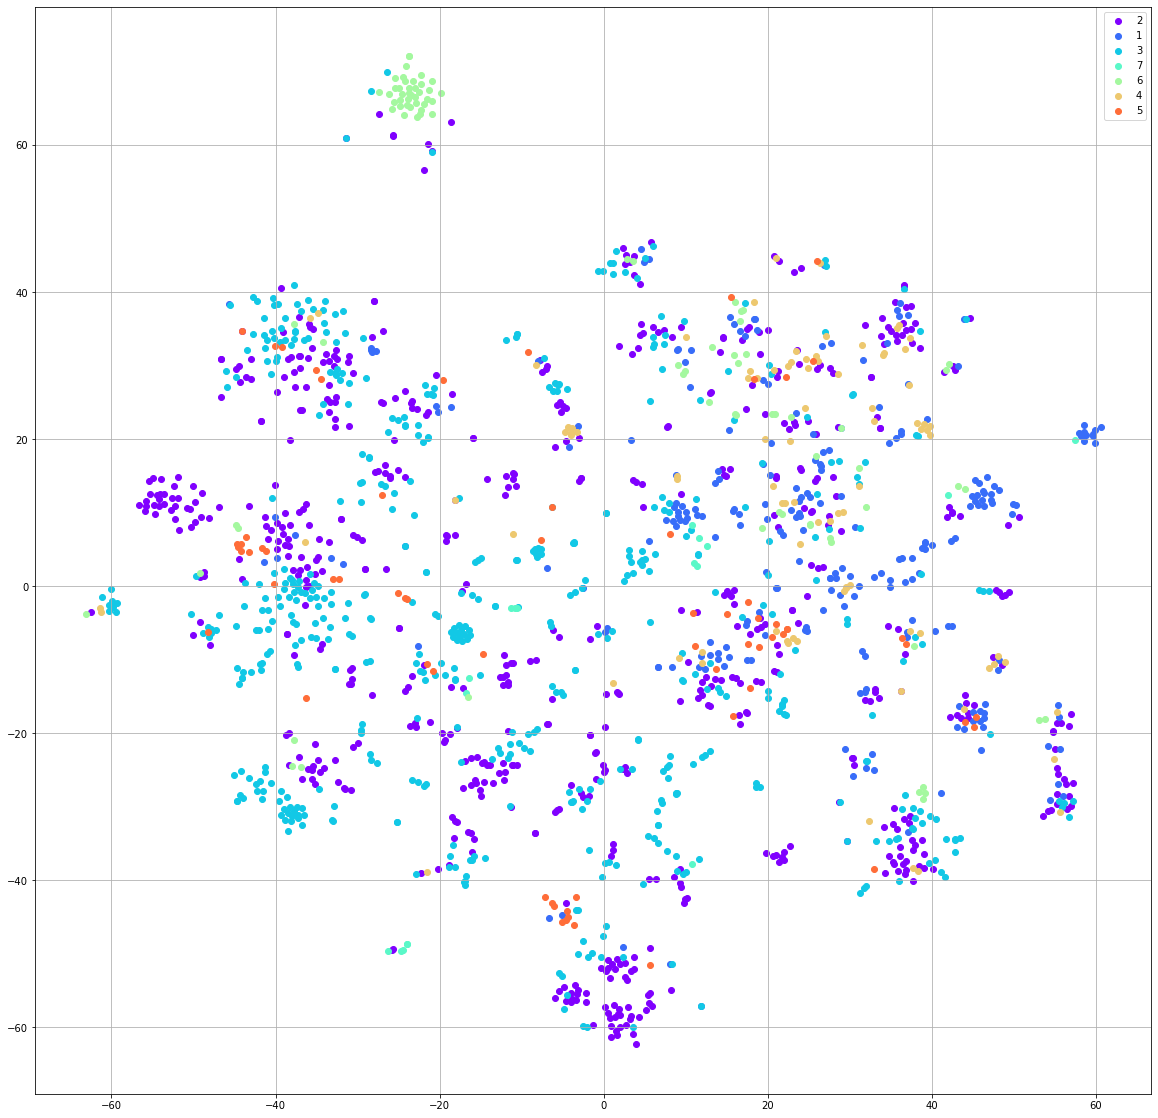

In [8]:
plotTSNE(wroEmbeddings, size)